# Build an interface between deepXDE and Altair Simulation

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# # load mesh and solver results
# op2File = 'data/controlArm/v1.0/controlArm01_nom.op2'
# geom = MeshGeom(op2File, thickness=0.1)
# plotScalarFields(geom.mesh, geom.resDf)

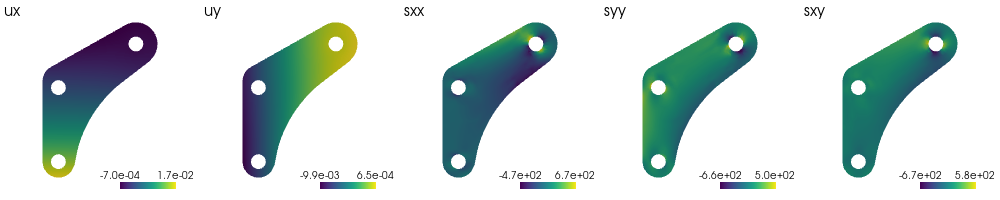

In [3]:
# load using the alternative format
meshFile = 'data/controlArm/v1.0/controlArm01_nom.vtk'
pickleFile = 'data/controlArm/v1.0/controlArm01_nom.p'
geom = MeshGeom(meshFile=meshFile, pickleFile=pickleFile)
plotScalarFields(geom.mesh, geom.resDf)

Compiling model...
Building feed-forward neural network...
'build' took 0.067820 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.320029 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.00e-03, 1.27e-02, 2.76e+09, 1.43e+09, 2.07e+07, 6.17e-03, 1.10e-02, 9.93e-03, 1.36e-02, 3.64e+04, 1.78e-02, 3.06e-03, 1.86e-03]    [1.04e-03, 1.28e-02, 2.83e+09, 1.47e+09, 2.07e+07, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
100       [2.25e-03, 4.39e-03, 2.77e+05, 3.06e+05, 8.41e+04, 2.26e-05, 1.47e-05, 9.96e-03, 1.07e-02, 3.64e+04, 5.46e-03, 3.61e-04, 3.15e-04]    [2.39e-03, 4.33e-03, 1.79e+05, 2.00e+05, 5.58e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
200       [9.63e-04, 3.35e-03, 1.24e+05, 2.03e+05, 7.03e+04, 1.36e-05, 6

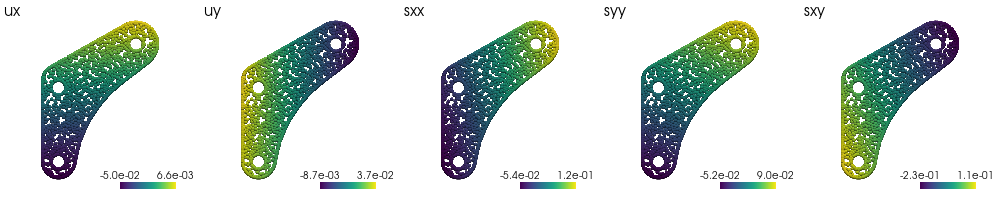

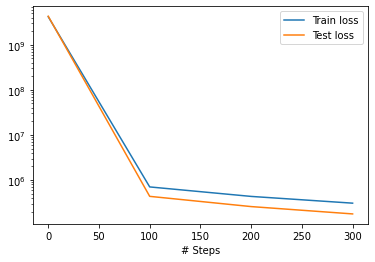

In [4]:
# supports
xBc = SupportBC(geom, bndId=1, U=0, component=0)
yBc = SupportBC(geom, bndId=1, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)
xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# external loads
Fx = 22 # N
xTr2 = TractionBC(geom, bndId=2, T=Fx/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:50, 2:50, 3:50}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# train
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=300, display_every=100)
dde.postprocessing.plot_loss_history(losshistory)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

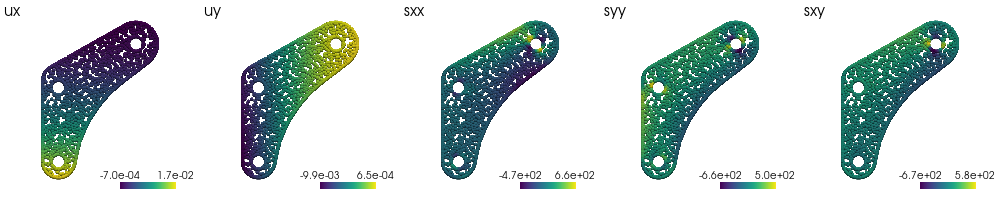

In [5]:
intResDf = geom.sampleRes(data.train_x)
plotScalarFields(pc, intResDf)

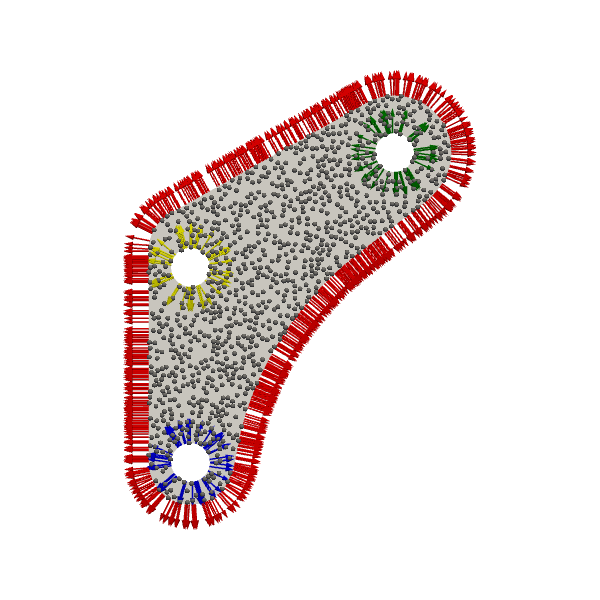

In [6]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), colors):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');